<a href="https://colab.research.google.com/github/yashveersinghsohi/machine_hack_competitions/blob/baseline_model_diagnostics/Data_Science_Student_Championship/Baseline_Model/baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Git Clone

In [2]:
# !git clone -b baseline_model https://github.com/yashveersinghsohi/machine_hack_competitions.git
# !git clone -b baseline_model_diagnostics https://github.com/yashveersinghsohi/machine_hack_competitions.git

# Imports

In [21]:
# !pip install shap

In [52]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LearningCurveDisplay, learning_curve, ShuffleSplit

# Datasets

In [4]:
root_dir = '/content/machine_hack_competitions/Data_Science_Student_Championship/Features/'
X_train = pd.read_csv(root_dir+'X_train.csv')
y_train = pd.read_csv(root_dir+'y_train.csv')

X_val = pd.read_csv(root_dir+'X_val.csv')
y_val = pd.read_csv(root_dir+'y_val.csv')

X_test = pd.read_csv(root_dir+'X_test.csv')
y_test = pd.read_csv(root_dir+'y_test.csv')

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((167738, 20), (167738, 1), (41935, 20), (41935, 1), (89861, 20), (89861, 1))

# Baseline XGBoost Regression

In [5]:
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train.to_numpy().reshape(-1,))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [6]:
def calculate_metrics(datasets, model):
  X, y = datasets
  mae = mean_absolute_error(y_true=y, y_pred=model.predict(X)).round(4)
  mse = mean_squared_error(y_true=y, y_pred=model.predict(X)).round(4)
  rmse = np.sqrt(mse).round(4)
  msle = mean_squared_log_error(y_true=y, y_pred=np.where(model.predict(X) < 0, 0, model.predict(X))).round(4)
  rmsle = np.sqrt(msle).round(4)
  return {'mae': mae, 'rmse': rmse, 'rmsle': rmsle}

**Train Metrics**

In [7]:
datasets = X_train, y_train.to_numpy().reshape(-1,)
calculate_metrics(datasets=datasets, model=xgb)

{'mae': 5.2071, 'rmse': 21.646, 'rmsle': 0.1536}

**Val Metrics**

In [8]:
datasets = X_val, y_val.to_numpy().reshape(-1,)
calculate_metrics(datasets=datasets, model=xgb)

{'mae': 6.7944, 'rmse': 40.0667, 'rmsle': 0.1871}

# Submission

In [10]:
def create_submission(
    model, X, 
    submission_path='/content/machine_hack_competitions/Data_Science_Student_Championship/Competition_Files/submission.csv'
  ):
  X_copy = X.copy()
  X_copy['fare_pred'] = model.predict(X)
  submission_df = pd.read_csv(submission_path)
  submission_df['total_fare'] = X_copy['tip'] + X_copy['miscellaneous_fees'] + X_copy['fare_pred']
  submission_df['total_fare'] = np.where(submission_df['total_fare'] < 0, 0, submission_df['total_fare'])
  print(submission_df.head())
  submission_df.to_csv('submission.csv', index=False)

In [11]:
# create_submission(model=xgb, X=X_test)

# Model Diagnostics

In [13]:
train = X_train.copy()
train['fare'] = y_train['fare']
train['pred'] = xgb.predict(X_train)

val = X_val.copy()
val['fare'] = y_val['fare']
val['pred'] = xgb.predict(X_val)

test = X_test.copy()
test['fare'] = y_test['fare']
test['pred'] = xgb.predict(X_test)

<Axes: ylabel='Frequency'>

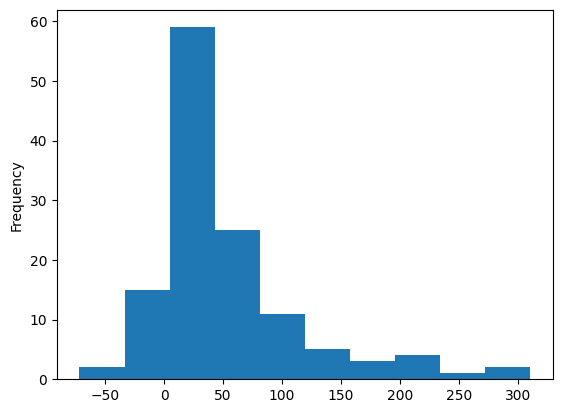

In [16]:
train[train['fare'] == 0]['pred'].plot.hist()

<Axes: ylabel='Frequency'>

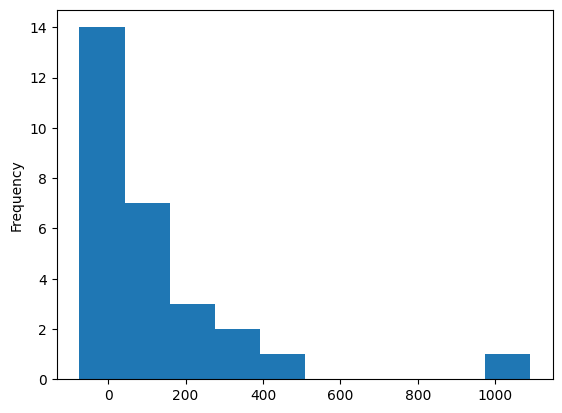

In [17]:
val[val['fare'] == 0]['pred'].plot.hist()

In [23]:
explainer = shap.TreeExplainer(xgb)

In [30]:
pd.DataFrame({'Features': X_train.columns, 'Importances': xgb.feature_importances_}).sort_values(by=['Importances'], ascending=[False])

,Features,Importances
1,distance_traveled,0.567232
0,trip_duration,0.097148
5,surge_applied,0.082501
4,miscellaneous_fees,0.060188
15,is_miscellaneous_fees_0,0.052821
3,tip,0.048975
8,hbos_is_row_outlier,0.028298
2,num_of_passengers,0.027130
6,iforest_is_row_outlier,0.020500
7,cblof_is_row_outlier,0.015208


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


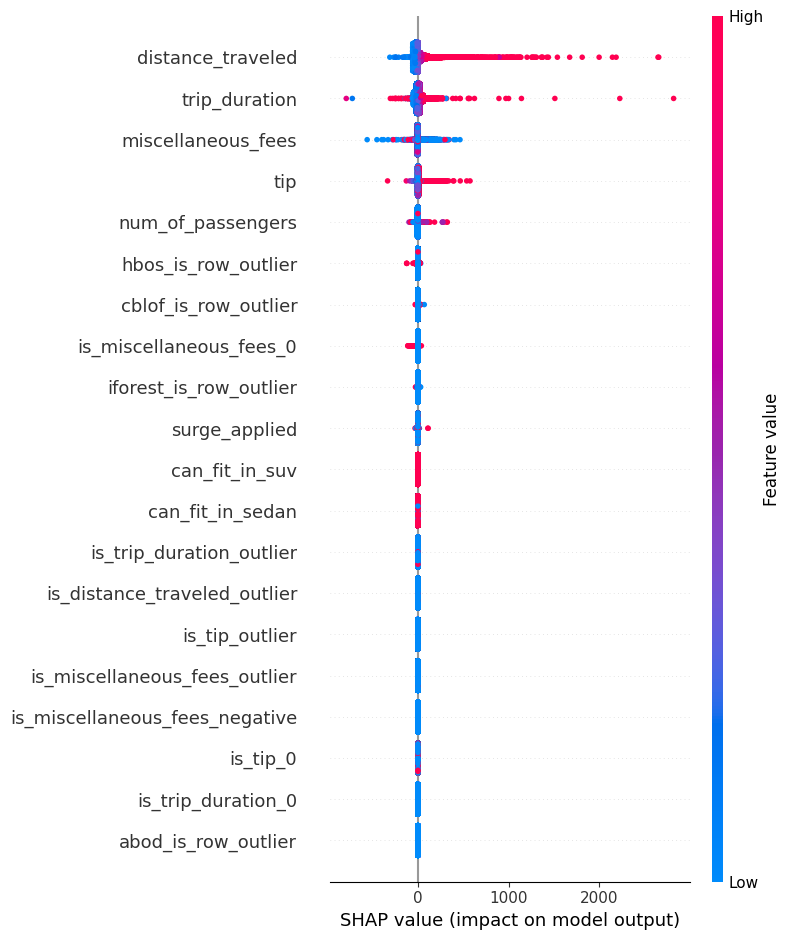

In [24]:
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

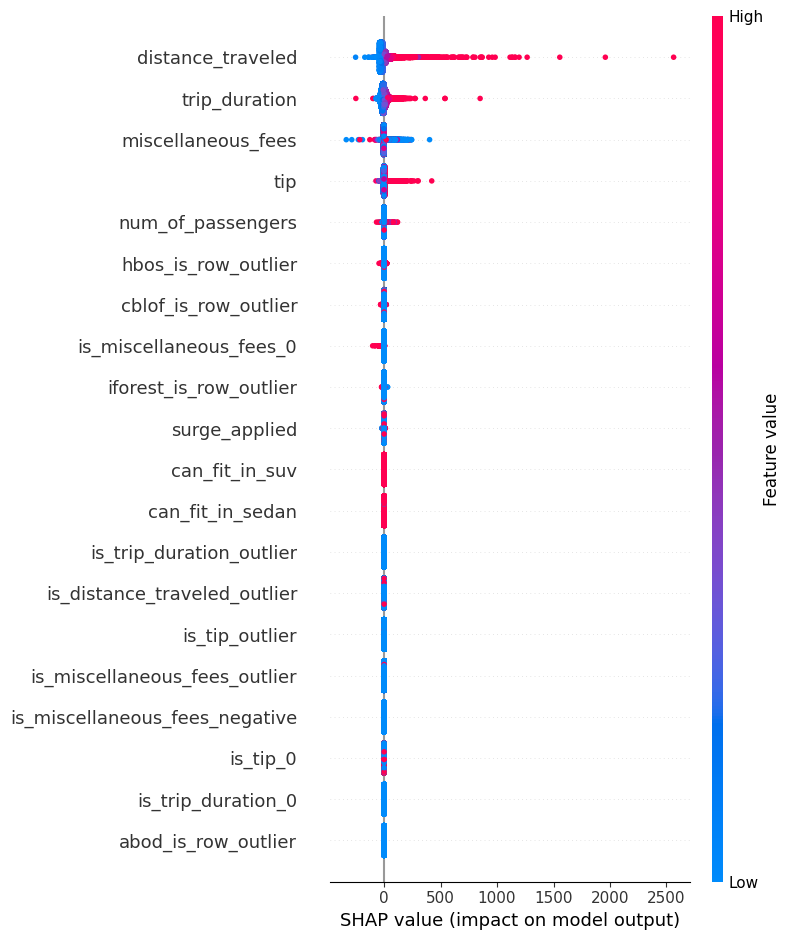

In [25]:
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val)

In [31]:
X_train.columns

Index(['trip_duration', 'distance_traveled', 'num_of_passengers', 'tip',
       'miscellaneous_fees', 'surge_applied', 'iforest_is_row_outlier',
       'cblof_is_row_outlier', 'hbos_is_row_outlier', 'abod_is_row_outlier',
       'is_trip_duration_outlier', 'is_distance_traveled_outlier',
       'is_tip_outlier', 'is_miscellaneous_fees_outlier',
       'is_miscellaneous_fees_negative', 'is_miscellaneous_fees_0', 'is_tip_0',
       'is_trip_duration_0', 'can_fit_in_sedan', 'can_fit_in_suv'],
      dtype='object')

In [32]:
features = ['trip_duration', 'distance_traveled', 'num_of_passengers', 'tip', 'miscellaneous_fees', 'surge_applied']
xgb_small = XGBRegressor(random_state=42)
xgb_small.fit(X_train[features], y_train.to_numpy().reshape(-1,))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [36]:
datasets = X_train[features], y_train.to_numpy().reshape(-1,)
calculate_metrics(datasets=datasets, model=xgb_small)

{'mae': 5.2111, 'rmse': 21.605, 'rmsle': 0.1549}

In [37]:
datasets = X_val[features], y_val.to_numpy().reshape(-1,)
calculate_metrics(datasets=datasets, model=xgb_small)

{'mae': 6.7059, 'rmse': 39.6029, 'rmsle': 0.1926}

In [39]:
create_submission(model=xgb_small, X=X_test[features])

   total_fare
0  110.811546
1   63.279453
2  116.345375
3   90.373878
4  115.480728


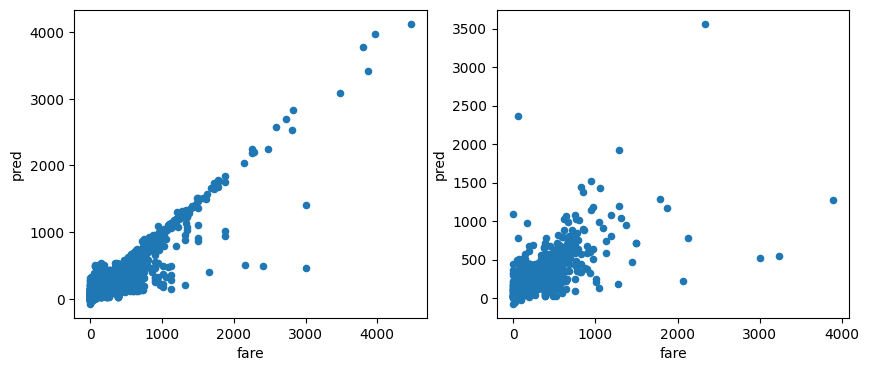

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
train[['fare', 'pred']].plot.scatter(x='fare', y='pred', ax=ax[0])
val[['fare', 'pred']].plot.scatter(x='fare', y='pred', ax=ax[1])
plt.show()

In [49]:
train['pred_small'] = xgb_small.predict(X_train[features])
val['pred_small'] = xgb_small.predict(X_val[features])

In [50]:
X = pd.concat([X_train, X_val])
y = pd.concat([y_train, y_val])

In [51]:
X.shape, y.shape

((209673, 20), (209673, 1))

KeyboardInterrupt: ignored

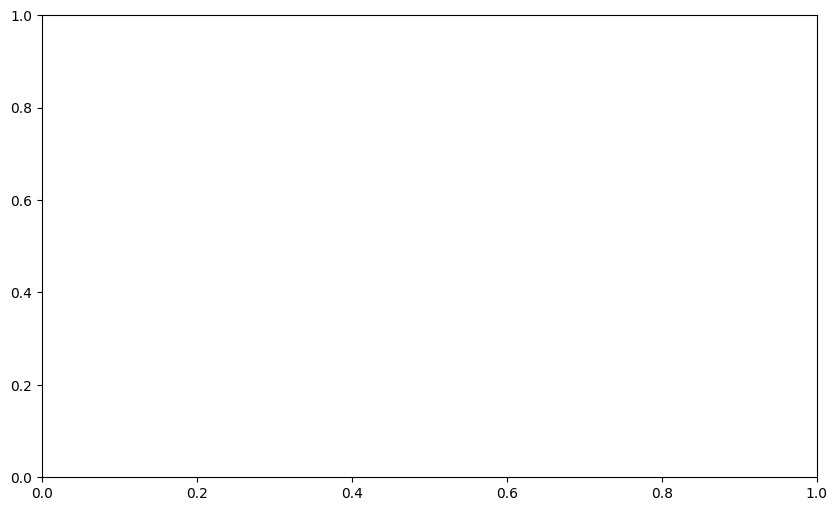

In [53]:
fig, ax = plt.subplots(figsize=(10, 6))

common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}
LearningCurveDisplay.from_estimator(xgb_small, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for Small XGBoost Model")
plt.show()